# Klasyfikacja na danych numerycznych

In [1]:
from IPython.display import display
import pandas as pd

from ium_long_stay_patterns.src.helpers.create_numerical_dataset import create_numerical_dataset, merge_with_stats
from ium_long_stay_patterns.config import ProcessedCSV, ModelParams
from models.binary import BinaryClassifier
from models.naive import NaiveZeroClassifier

import torch
import torch.nn as nn
import torch.optim as optim

from ium_long_stay_patterns.modeling.train import Trainer

from ium_long_stay_patterns.src.helpers.plotting import plot_confusion_matrix

from ium_long_stay_patterns.src.helpers.data_loaders import prepare_and_create_loaders

from ium_long_stay_patterns.config import SAVED_MODELS_DIR, TEST_DATA_DIR

import joblib

2026-01-13 19:25:32.778 | INFO     | ium_long_stay_patterns.config:<module>:14 - PROJ_ROOT path is: /home/matimat/IUM/ium-long-stay-patterns


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [3]:
df_numeric = create_numerical_dataset(ProcessedCSV.LISTINGS.path, strategy=True)
df_final = merge_with_stats(df_numeric, with_ids=True)

X = df_final.drop(columns=['target'])
y = df_final['target']

params = ModelParams()

In [4]:
import json
import numpy as np
import pandas as pd

sel = df_final[df_final['target'] == 1].drop(columns=['target']).head(5)

def _convert(val):
    if pd.isna(val):
        return None
    if isinstance(val, (np.integer,)):
        return int(val)
    if isinstance(val, (np.floating,)):
        return float(val)
    if isinstance(val, (np.bool_,)):
        return bool(val)
    if isinstance(val, np.ndarray):
        return val.tolist()
    return val

records = [{k: _convert(v) for k, v in row.items()} for row in sel.to_dict(orient='records')]
file_path = TEST_DATA_DIR / "test_targets_1.json"
with open(file_path, "w", encoding="utf-8") as f:
    json.dump(records, f, indent=2, ensure_ascii=False)

print(f"Successfully saved {len(records)} records to {file_path}")

Successfully saved 5 records to /home/matimat/IUM/ium-long-stay-patterns/prediction_service/test_data/test_targets_1.json


In [5]:
train_loader, val_loader, test_loader, fitted_scaler = prepare_and_create_loaders(X, y, batch_size=params.batch_size)


Train set size: 875 (239.0 positive)
Validation set size: 219 (60.0 positive)
Test set size: 274
Features: 21
Total positive samples in train set: 239.0


In [6]:
joblib.dump(fitted_scaler, SAVED_MODELS_DIR / "binary_scaler.joblib")

['/home/matimat/IUM/ium-long-stay-patterns/saved_models/binary_scaler.joblib']

## Model setup from best trial in *parameters_tuning.ipynb*

In [7]:
data_iter = iter(train_loader)
images, labels = next(data_iter)
input_dim = images.shape[1]

model = BinaryClassifier(input_dim, params.layers, dropout_rate=params.dropout_rate).to(device)

model


BinaryClassifier(
  (network): Sequential(
    (0): Linear(in_features=21, out_features=16, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.30000000000000004, inplace=False)
    (3): Linear(in_features=16, out_features=80, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.30000000000000004, inplace=False)
    (6): Linear(in_features=80, out_features=128, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.30000000000000004, inplace=False)
    (9): Linear(in_features=128, out_features=1, bias=True)
    (10): Sigmoid()
  )
)

In [8]:
criterion = nn.BCELoss()
optimizer = optim.Adam(
    model.parameters(), 
    lr=params.learning_rate, 
    weight_decay=params.weight_decay
)

trainer = Trainer(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    epochs=100
)


In [9]:
trainer.train(train_loader, val_loader)

2026-01-13 19:25:39.312 | INFO     | ium_long_stay_patterns.modeling.train:train:29 - Training started on device: cuda


2026-01-13 19:25:39.933 | INFO     | ium_long_stay_patterns.modeling.train:train:57 - Epoch 001 | Avg Loss: 0.5804 | AUC: 0.7744 | F1: 0.0923 | P: 0.6000 | R: 0.0500


2026-01-13 19:25:41.258 | INFO     | ium_long_stay_patterns.modeling.train:train:57 - Epoch 010 | Avg Loss: 0.3943 | AUC: 0.8730 | F1: 0.6435 | P: 0.6727 | R: 0.6167


2026-01-13 19:25:42.963 | INFO     | ium_long_stay_patterns.modeling.train:train:57 - Epoch 020 | Avg Loss: 0.3375 | AUC: 0.8928 | F1: 0.5895 | P: 0.8000 | R: 0.4667


2026-01-13 19:25:44.709 | INFO     | ium_long_stay_patterns.modeling.train:train:57 - Epoch 030 | Avg Loss: 0.3187 | AUC: 0.9311 | F1: 0.7455 | P: 0.8200 | R: 0.6833


2026-01-13 19:25:46.428 | INFO     | ium_long_stay_patterns.modeling.train:train:57 - Epoch 040 | Avg Loss: 0.3164 | AUC: 0.9241 | F1: 0.7103 | P: 0.8085 | R: 0.6333


2026-01-13 19:25:48.114 | INFO     | ium_long_stay_patterns.modeling.train:train:57 - Epoch 050 | Avg Loss: 0.2683 | AUC: 0.9081 | F1: 0.6538 | P: 0.7727 | R: 0.5667


2026-01-13 19:25:49.815 | INFO     | ium_long_stay_patterns.modeling.train:train:57 - Epoch 060 | Avg Loss: 0.2517 | AUC: 0.9352 | F1: 0.7967 | P: 0.7778 | R: 0.8167


2026-01-13 19:25:51.569 | INFO     | ium_long_stay_patterns.modeling.train:train:57 - Epoch 070 | Avg Loss: 0.2455 | AUC: 0.9371 | F1: 0.7500 | P: 0.8077 | R: 0.7000


2026-01-13 19:25:53.319 | INFO     | ium_long_stay_patterns.modeling.train:train:57 - Epoch 080 | Avg Loss: 0.2215 | AUC: 0.9418 | F1: 0.7521 | P: 0.7719 | R: 0.7333


2026-01-13 19:25:55.126 | INFO     | ium_long_stay_patterns.modeling.train:train:57 - Epoch 090 | Avg Loss: 0.2258 | AUC: 0.9403 | F1: 0.7899 | P: 0.7966 | R: 0.7833


2026-01-13 19:25:56.956 | INFO     | ium_long_stay_patterns.modeling.train:train:57 - Epoch 100 | Avg Loss: 0.2110 | AUC: 0.9362 | F1: 0.7652 | P: 0.8000 | R: 0.7333


In [10]:
test_metrics = trainer._validate(test_loader)
print(f"Final Test ROC AUC: {test_metrics['auc']:.4f}")
print(f"Final Test F1-Score: {test_metrics['f1']:.4f}")



Final Test ROC AUC: 0.9264
Final Test F1-Score: 0.6906


F1-score jest **wieksze** niz założone w analitycznym kryterium( **0.69** > 0.65).
Roc Auc na poziomie **0.92** oznacza, że model solidnie separuje klasy.

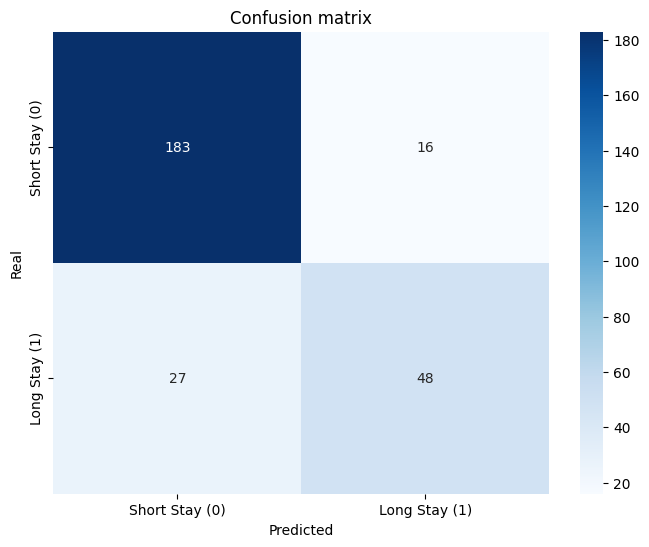


Classification Report:
              precision    recall  f1-score   support

         0.0       0.87      0.92      0.89       199
         1.0       0.75      0.64      0.69        75

    accuracy                           0.84       274
   macro avg       0.81      0.78      0.79       274
weighted avg       0.84      0.84      0.84       274



In [11]:
trainer.model.eval()
all_preds = []
all_true = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = trainer.model(batch_X.to(trainer.device))
        preds = (outputs > 0.5).float()
        all_preds.extend(preds.cpu().numpy())
        all_true.extend(batch_y.numpy())

plot_confusion_matrix(np.array(all_true), np.array(all_preds))

Precyzja dla klasy **long_stay**=1 wynosi 0.69, co dla danych niezbalansowanych jest dość dobrym wynikiem który satysfakcjonuje założone analityczne kryterium sukcesu.

In [12]:
trainer.save_model(SAVED_MODELS_DIR / "binary_classifier_model.pth")

2026-01-13 19:25:57.360 | INFO     | ium_long_stay_patterns.modeling.train:save_model:91 - Model saved to /home/matimat/IUM/ium-long-stay-patterns/saved_models/binary_classifier_model.pth


# Model Naiwny

In [13]:
naive_model = NaiveZeroClassifier()

In [14]:
naive_trainer = Trainer(model=naive_model, criterion=None, optimizer=None)
naive_metrics = naive_trainer._validate(test_loader)

In [15]:
print(f"Final Test ROC AUC: {naive_metrics['auc']:.4f}")
print(f"Final Test F1-Score: {naive_metrics['f1']:.4f}")
print(f"Precision: {naive_metrics['precision']:.4f}")
print(f"Recall:    {naive_metrics['recall']:.4f}")

Final Test ROC AUC: 0.5000
Final Test F1-Score: 0.0000
Precision: 0.0000
Recall:    0.0000


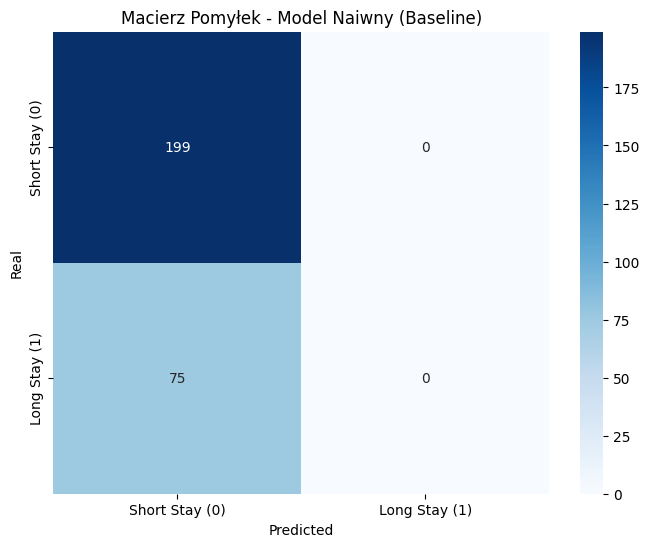


Classification Report:
              precision    recall  f1-score   support

         0.0       0.73      1.00      0.84       199
         1.0       0.00      0.00      0.00        75

    accuracy                           0.73       274
   macro avg       0.36      0.50      0.42       274
weighted avg       0.53      0.73      0.61       274



/home/matimat/.cache/pypoetry/virtualenvs/ium-long-stay-patterns-kVcCAgnW-py3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/matimat/.cache/pypoetry/virtualenvs/ium-long-stay-patterns-kVcCAgnW-py3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/matimat/.cache/pypoetry/virtualenvs/ium-long-stay-patterns-kVcCAgnW-py3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0

In [16]:
all_true = []
all_preds = []

naive_model.eval()
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = naive_model(batch_X)
        all_preds.extend(outputs.cpu().numpy())
        all_true.extend(batch_y.numpy())

# Rysowanie macierzy
plot_confusion_matrix(
    np.array(all_true),
    np.array(all_preds),
    title='Macierz Pomyłek - Model Naiwny (Baseline)'
)

In [17]:
trainer.save_model(SAVED_MODELS_DIR / "naive_classifier_model.pth")

2026-01-13 19:25:57.679 | INFO     | ium_long_stay_patterns.modeling.train:save_model:91 - Model saved to /home/matimat/IUM/ium-long-stay-patterns/saved_models/naive_classifier_model.pth


# TODO podsumowanie modeli itp
